In [95]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import numpy as np
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torch
import json

import matplotlib.pyplot as plt
%matplotlib inline

import sys

import os
from datetime import datetime
import time
import random
import pandas as pd
from torch.utils.data.sampler import SequentialSampler, RandomSampler
import torch.nn as nn
from glob import glob
from eval.mAP import *

from icecream import ic


SEED = 42
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [96]:

def get_train_transforms():
    return A.Compose(
        [
            A.RandomSizedCrop(min_max_height=(700, 700), height=1024, width=1024, p=0.5),
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9),
            ],p=0.0),
            #A.ToGray(p=0.01),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Resize(height=512, width=512, p=1),
            A.Cutout(num_holes=2, max_h_size=32, max_w_size=32, fill_value=0, p=0.5),
            ToTensorV2(p=1.0),

        ], p = 1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
            
        )
    )
    
def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

def get_reshape_transforms():
    return A.Compose(
    [
        A.RandomResizedCrop( height=100, width=100, p=1), 
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Cutout(num_holes=2, max_h_size=10, max_w_size=10, fill_value=1, p=0.5),
        A.Rotate(limit = (-180, 180)),
        A.ShiftScaleRotate(p = 0.5),
        A.IAAAffine(p = 0.5),

    ], p = 1.0, )

def get_jitter_transforms():
    return A.Compose(
        [
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9),
            ],p=0.9),
            A.GaussianBlur(p = 0.5),
            A.ChannelShuffle(p = 0.1),
            A.RGBShift(p = 0.1),
            #A.ToGray(p=0.05),    

        ], p=1.0)

def get_random_resized_transforms():
    return A.Compose(
        [
                A.OneOf([
                    A.Resize(height=50, width=50, p=1),
                    A.Resize(height=100, width=100, p=1),
                    A.Resize(height=159, width=150, p=1),
                    A.Resize(height=200, width=200, p=1),
                    A.Resize(height=150, width=200, p=1),
                    A.Resize(height=200, width=150, p=1),
                    A.Resize(height=100, width=200, p=1),
                    A.Resize(height=200, width=100, p=1),
                ],p = 0.9)
        ]
    )

In [113]:
STAGE_PATH = "/home/ubuntu/data/sumaDetData/DetStage"
ANNO_PATH = "/home/ubuntu/data/sumaDetData/export-2021-01-20T11_25_42.944Z.json"
CLASSES = ["gake"]
CHARACTOR_PATH = "/home/ubuntu/data/sumaDetData/sumaCharactors"
CHARACTOR_NAMES = os.listdir(CHARACTOR_PATH)
CLASSES.extend(CHARACTOR_NAMES)

class DatasetRetriever(Dataset):

    def __init__(self, transforms=None, valid=False, charactor_num = 2):
        super().__init__()
        self.transforms = transforms
        self.valid = valid
        self.stage_names, self.box_and_label = self.load_annotation()
        self.charactor_num = charactor_num
        
    def __getitem__(self, index: int):
        stage_name = self.stage_names[index]
        image = self.load_image(index)
        image, boxes, labels = self.charactor_bbox_generator(image, self.charactor_num)

        target = {}
        target['boxes'] = np.concatenate([self.box_and_label[stage_name]["boxes"],boxes ], axis = 0)
        target['labels'] = torch.tensor(np.concatenate([self.box_and_label[stage_name]["labels"], labels], axis = 0))

        target['image_id'] = torch.tensor([index])
        
        if self.transforms:
            for i in range(10):
                sample = self.transforms(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': target["labels"],
                })
                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  #yxyx: be warning
                    target["labels"] = torch.tensor(sample["labels"])
                    break

        return image, target, index
    
    def __len__(self) -> int:
        return len(self.stage_names)
    
    def load_annotation(self):
        with open(ANNO_PATH, "rb") as f:
            anno = json.load(f)
        stage_names = []
        boxes_and_labels = {}
        for i in anno:
            stage_name = i["External ID"]
            stage_names.append(stage_name)
            b = []
            l = []
            for x in i["Label"]["objects"]:
                boxes = x["bbox"]
                boxes = [i for i in boxes.values()]
                b.append(self.xywh2xyxy(boxes))
                l.append(CLASSES.index(x["value"]) + 1)
            boxes_and_labels[stage_name] = {"boxes":b, "labels":l}
        return stage_names, boxes_and_labels

    def load_image(self, index):
        stage_name = self.stage_names[index]
        image = cv2.imread(f'{STAGE_PATH}/{stage_name}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        return image
    
    def xywh2xyxy(self, box):
        min_y, min_x, height, width = box
        x1, y1, x2, y2 = min_x, min_y, min_x + width, min_y + height
        return [x1, y1, x2, y2]
    
    
    def charactor_bbox_generator(self, stage_img, charactor_num = 2):
        charactor_ids = [random.randint(0, len(CHARACTOR_NAMES)-1) for _ in range(charactor_num)]
        result = stage_img[:]
        boxes = []
        classes = []
        for c_id in charactor_ids:
            charactor_name = CHARACTOR_NAMES[c_id]
            charactor_color = f'00{str(random.randint(1,8))}.png'
            _cimage = cv2.imread(f'{CHARACTOR_PATH}/{charactor_name}/{charactor_color}', cv2.IMREAD_COLOR)
            _cimage = cv2.cvtColor(_cimage, cv2.COLOR_BGR2RGB).astype(np.float32)
            _cimage /= 255.0
            
            transform_shape = get_reshape_transforms()
            _cimage = transform_shape(image = _cimage)["image"]

            pos = self.generate_position(H = result.shape[0], W = result.shape[1])

            transform_size = get_random_resized_transforms()
            _cimage = transform_size(image = _cimage)["image"]

            y1, y2, x1, x2 = pos[0], pos[0] + _cimage.shape[0], pos[1], pos[1] + _cimage.shape[1]
            boxes.append([x1, y1, x2, y2])

            transparent_img = np.zeros(result.shape)
            transparent_img[y1:y2, x1:x2] = _cimage

            transform_color = get_jitter_transforms()
            _cimage = transform_color(image = _cimage)["image"]

            back_img = np.zeros(result.shape)
            back_img[y1:y2, x1:x2] = _cimage

            transparence = (0,0,0)
            result = np.where(transparent_img==transparence, result, back_img)

            classes.append(CLASSES.index(charactor_name) + 1)
        return result, boxes, classes

    def generate_position(self,H = 780,W = 1280):
        return [random.randint(0, H - 250),random.randint(0, W - 250)]


In [114]:

train_dataset = DatasetRetriever(
    transforms=get_train_transforms(),
    valid=False,
    charactor_num = 4
)

validation_dataset = DatasetRetriever(
    transforms=get_valid_transforms(),
    valid=True,
    charactor_num = 2
)

1.0
0.0
gake
リトル・マック
ロックマン
スティーブ


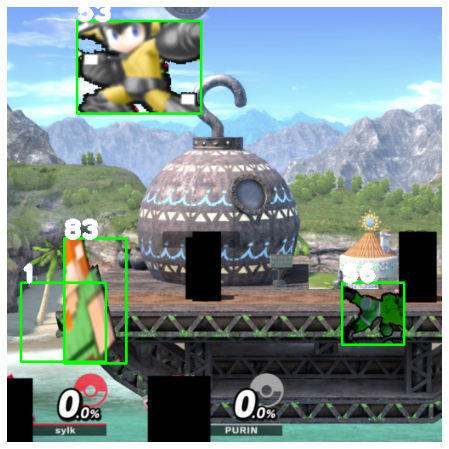

In [124]:
image, target, image_id = validation_dataset[0]
image, target, image_id = train_dataset[0]

boxes = target['boxes'].cpu().numpy().astype(np.int32)
labels = target["labels"].cpu().numpy().astype(np.int)


numpy_image = image.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box, label in zip(boxes, labels):
    print(CLASSES[label-1])
    cv2.rectangle(numpy_image, (box[1], box[0]), (box[3],  box[2]), (0, 1, 0), 2)
    cv2.putText(numpy_image, str(label), (box[1], box[0]), cv2.FONT_HERSHEY_PLAIN, 2, (255, 255, 255), 5, cv2.LINE_AA)

    
ax.set_axis_off()
ax.imshow(numpy_image)
plt.show()

In [116]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [153]:
import warnings

warnings.filterwarnings("ignore")

class Fitter:
    
    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0

        self.base_dir = f'./{config.folder}'
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)
        
        self.log_path = f'{self.base_dir}/log.txt'
        self.best_summary_loss = 10**5
        self.model = model
        self.device = device

        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ] 

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=config.lr)
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.log(f'Fitter prepared. Device is {self.device}')

    def fit(self, train_loader, validation_loader):
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            summary_loss = self.train_one_epoch(train_loader)

            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            self.save(f'{self.base_dir}/last-checkpoint.bin')

            t = time.time()
            summary_loss, mean_AP = self.validation(validation_loader)

            self.log(f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            if summary_loss.avg < self.best_summary_loss:
                self.best_summary_loss = summary_loss.avg
                self.model.eval()
                self.save(f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin')
                for path in sorted(glob(f'{self.base_dir}/best-checkpoint-*epoch.bin'))[:-3]:
                    os.remove(path)
            count = 0
            for c in mean_AP.keys():
                count += 1
                print(c, mean_AP[c])
                if count == 3:
                    break
            

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=summary_loss.avg)

            self.epoch += 1

    def validation(self, val_loader):
        self.model.eval()
        summary_loss = AverageMeter()
        t = time.time()
        det_boxes = []
        det_scores = []
        det_labels = []
        true_boxes = []
        true_labels = []
        true_difficulties = []
        for step, (images, targets, image_ids) in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Val Step {step}/{len(val_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            with torch.no_grad():
                images = torch.stack(images)
                batch_size = images.shape[0]
                images = images.to(self.device).float()
                boxes = [target['boxes'].to(self.device).float() for target in targets]
                labels = [target['labels'].to(self.device).float() for target in targets]

                target_res = {}
                target_res['bbox'] = boxes
                target_res['cls'] = labels 
                target_res["img_scale"] = torch.tensor([1.0] * batch_size, dtype=torch.float).to(self.device)
                target_res["img_size"] = torch.tensor([images[0].shape[-2:]] * batch_size, dtype=torch.float).to(self.device)

                outputs = self.model(images, target_res)
                loss = outputs["loss"]
                summary_loss.update(loss.detach().item(), batch_size)
                for i in range(batch_size):
                    det_boxes.append(outputs["detections"][i,:10,:4])
                    det_scores.append(outputs["detections"][i,:10,4])
                    det_labels.append(outputs["detections"][i,:10,5])
                    true_boxes.append(boxes[i][:,[1,0,3,2]])
                    true_labels.append(labels[i])
                    true_difficulties.append(torch.tensor([0] * len(labels[i])))
  
                                        
        mean_AP = calculate_mAP(det_boxes, det_labels, det_scores,
                                true_boxes, true_labels, true_difficulties,
                                CLASSES)
        print(det_boxes[0][0])
        print(boxes[0][0])
        return summary_loss, mean_AP[0]

    def train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(train_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Train Step {step}/{len(train_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )


            images = torch.stack(images)
            images = images.to(self.device).float()
            batch_size = images.shape[0]
            boxes = [target['boxes'].to(self.device).float() for target in targets]
            labels = [target['labels'].to(self.device).float() for target in targets]

            
            self.optimizer.zero_grad()

            output = self.model(images, {"bbox":boxes, "cls":labels})
            loss = output["loss"]
            
            loss.backward()

            summary_loss.update(loss.detach().item(), batch_size)

            self.optimizer.step()

            if self.config.step_scheduler:
                self.scheduler.step()
        return summary_loss
    
    def save(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_summary_loss': self.best_summary_loss,
            'epoch': self.epoch,
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_summary_loss = checkpoint['best_summary_loss']
        self.epoch = checkpoint['epoch'] + 1
        
    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')

In [154]:
class TrainGlobalConfig:
    num_workers = 2
    batch_size = 4
    n_epochs = 1000 # n_epochs = 40
    lr = 0.0002

    folder = 'effdet5_charactors_d1'
    #folder = 'effdet5-cutmix-augmix-xyxy'


    # -------------------
    verbose = True
    verbose_step = 1
    # -------------------

    # --------------------
    step_scheduler = False  # do scheduler.step after optimizer.step
    validation_scheduler = True  # do scheduler.step after validation stage loss
    
    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params = dict(
        mode='min',
        factor=0.5,
        patience=1,
        verbose=False, 
        threshold=0.0001,
        threshold_mode='abs',
        cooldown=0, 
        min_lr=1e-8,
        eps=1e-08
    )
    # --------------------

In [155]:
def collate_fn(batch):
    return tuple(zip(*batch))

def run_training():
    device = torch.device('cuda:0')
    net.to(device)

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        sampler=RandomSampler(train_dataset),
        pin_memory=False,
        drop_last=True,
        num_workers=TrainGlobalConfig.num_workers,
        collate_fn=collate_fn,
    )
    val_loader = torch.utils.data.DataLoader(
        validation_dataset, 
        batch_size=TrainGlobalConfig.batch_size,
        num_workers=TrainGlobalConfig.num_workers,
        sampler=SequentialSampler(validation_dataset),
        pin_memory=False,
        collate_fn=collate_fn,
    )

    fitter = Fitter(model=net, device=device, config=TrainGlobalConfig)
    #fitter.load("effdet5-cutmix-augmix/last-checkpoint.bin")
    #fitter.load("effdet5_charactors/best-checkpoint-093epoch.bin")
    fitter.fit(train_loader, val_loader)

In [156]:
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet
def get_net():
    config = get_efficientdet_config('tf_efficientdet_d1')
    config.num_classes = len(CLASSES)
    config.image_size = (512,512)

    net = EfficientDet(config, pretrained_backbone=False)
    #checkpoint = torch.load("effdet5-cutmix-augmix/best-checkpoint-002epoch.bin")
    #net.load_state_dict(checkpoint['model_state_dict'])
    #checkpoint = torch.load('../input/efficientdet/efficientdet_d5-ef44aea8.pth')

    net.reset_head(num_classes=config.num_classes)

    net.class_net = HeadNet(config, num_outputs=config.num_classes)
    return DetBenchTrain(net, config)

net = get_net()
#net = nn.DataParallel(net)

In [158]:
run_training()


Fitter prepared. Device is cuda:0

2021-01-24T07:23:49.053973
LR: 0.0002


KeyboardInterrupt: 

In [15]:
def test_output(test_loader, weight = "effdet5_charactors/best-checkpoint-006epoch.bin"):
    checkpoint = torch.load(weight)
    net.model.load_state_dict(checkpoint['model_state_dict'])
    net.to('cuda:2')
    net.eval()
    summary_loss = AverageMeter()
    t = time.time()
    output_detections = []
    ids = []
    device = "cuda:2"
    for step, (images, targets, image_ids) in enumerate(test_loader):
        print("\r", image_ids, end = "")
        with torch.no_grad():
            #images = torch.stack(images)
            images = images.unsqueeze(0)
            batch_size = images.shape[0]
            images = images.to(device).float().to(device)
            boxes = torch.tensor([[0,1,2,3]]).float().to(device)
            labels = torch.tensor([1]).to(device)

            #loss= self.model(images, {"bbox":boxes, "cls":labels})["loss"]
            target_res = {}
            target_res['bbox'] = boxes
            target_res['cls'] = labels 
            target_res["img_scale"] = torch.tensor([1.0] * batch_size, dtype=torch.float).to(device)
            target_res["img_size"] = torch.tensor([images[0].shape[-2:]] * batch_size, dtype=torch.float).to(device)

            outputs = net(images, target_res)
            output_detections.append(outputs["detections"])
            ids.append(image_ids)


    return output_detections, ids
#o,ids = test_output(sub_dataset)
valid_o, _ = test_output(validation_dataset)

 102

torch.Size([1, 3, 512, 512])
tensor([0.0860, 0.0793, 0.0787, 0.0750, 0.0744], grad_fn=<SliceBackward>)
[482.6074  481.14908 512.      512.     ]
[456.82135 453.2264  512.      512.     ]
[484.47375    0.       512.        45.224815]
[477.4013    0.      512.       23.31916]
[ 0.        0.       29.323582 41.01799 ]


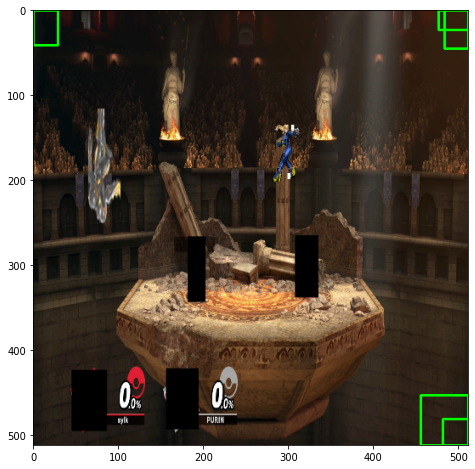

In [26]:
def visualize(idx, dataset,
              weight = "effdet5_charactors/best-checkpoint-095epoch.bin"):
    images, target, image_id = dataset[idx]
    device = "cuda:2"
    checkpoint = torch.load(weight)
    net.model.load_state_dict(checkpoint['model_state_dict'])
    net.to(device)
    net.eval()
    target_res = {}
    target_res['bbox'] = torch.tensor([[0,1,2,3]]).float().to(device)
    target_res['cls'] = torch.tensor([1]).to(device)
    target_res["img_scale"] = torch.tensor([1.0], dtype=torch.float).to(device)
    target_res["img_size"] = torch.tensor([images.shape[-2:]], dtype=torch.float).to(device)
    target_img = images.unsqueeze(0).to(device).float().to(device)
    print(target_img.shape)
    model_out = net(target_img, target_res)["detections"]
    #model_out = outputs[0]
    #boxes = target['boxes'].cpu().numpy().astype(np.int32)
    bbox = model_out.cpu()[0, :, :4]
    score = model_out.cpu()[0, :, 4]
    c = model_out.cpu()[0, :, 5]
    print(score[:5])
    #nms_index = nms(bbox, score)
    #score,bbox, c = score[nms_index], bbox[nms_index], c[nms_index]
    #print(len(score),score)
    #th = 0.2
    #score,bbox, c = score[nms_index.unsqueeze(1)], bbox[nms_index].detach().numpy().astype(np.int32), c[nms_index]
    #index = score > th
    #score, bbox, c = score[index], bbox[index], c[index]
    #print(len(score))

    
    numpy_image = images.permute(1,2,0).cpu().numpy()
    numpy_image_resized = cv2.resize(numpy_image, (512, 512))

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in bbox[:5]:
        print(box.detach().numpy())
        box = box.detach().numpy()
        #cv2.rectangle(numpy_image_resized, (box[1], box[0]), (box[3],  box[2]), (0, 1, 0), 2)
        cv2.rectangle(numpy_image_resized, (box[0], box[1]), (box[2],  box[3]), (0, 1, 0), 2)

    #ax.set_axis_off()
    ax.imshow(numpy_image_resized)
    
        
visualize(1, validation_dataset)

torch.Size([1, 3, 512, 512])
482 481 512 512 0 2
ドンキーコング
484 0 512 45 0 1
マリオ
476 0 512 23 0 3
リンク
397 389 512 512 0 2
ドンキーコング
492 0 512 22 0 26
ガノンドロフ
0 457 55 512 0 32
ピット
498 0 512 25 0 63
リュウ
0 473 22 512 0 1
マリオ
0 481 25 512 0 32
ピット
460 452 512 512 0 2
ドンキーコング


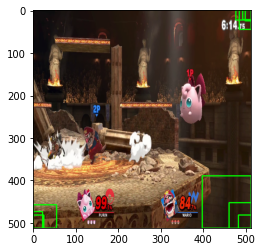

In [28]:
def video_process(video_path = '/home/ubuntu/data/sumaDetData/2020-11-10_20-30-56.mp4',
                  weight = "effdet5_charactors/best-checkpoint-095epoch.bin",
                 transform = None):
    cap = cv2.VideoCapture(video_path)
    checkpoint = torch.load(weight)
    net.model.load_state_dict(checkpoint['model_state_dict'])
    device = "cuda:2"
    net.to(device)
    net.eval()
    cap.set(cv2.CAP_PROP_POS_FRAMES, 2900)

    while True:
        ret, frame = cap.read()
        if ret:
            with torch.no_grad():
                _cimage = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB).astype(np.float32)
                _cimage /= 255.0
                img = transform(image = _cimage,
                                bboxes = [[0,10,20,30]],
                                labels = [0])
                
                target_res = {}
                target_res['bbox'] = torch.tensor([[0,1,2,3]]).float().to(device)
                target_res['cls'] = torch.tensor([1]).to(device)
                target_res["img_scale"] = torch.tensor([1.0], dtype=torch.float).to(device)
                target_res["img_size"] = torch.tensor([img["image"].shape[-2:]], dtype=torch.float).to(device)
                target_img = img["image"].unsqueeze(0).to(device).float().to(device)
                print(target_img.shape)
                outputs = net(target_img, target_res)["detections"]
                outputs = outputs[0].cpu().detach().numpy()

                resized_image = cv2.resize(_cimage, (512, 512))
                for out in outputs[:10]:
                    x1,y1,x2,y2,s,c = [int(i) for i in out]
                    print(x1, y1, x2, y2,s, c)
                    cv2.rectangle(resized_image, (int(x1), int(y1)),
                                  (int(x2),  int(y2)), (0, 1, 0), 2)
                    print(CLASSES[int(c)])

                plt.imshow(resized_image)
                plt.show()
                break
        else:
            break
video_process(transform = get_valid_transforms())

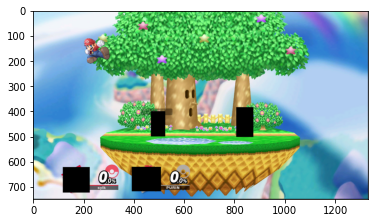

In [18]:
CHARACTOR_PATH = "/home/ubuntu/data/sumaDetData/sumaCharactors"
CHARACTOR_NAMES = os.listdir(CHARACTOR_PATH)
charactor_name = CHARACTOR_NAMES[0]
_cimage = cv2.imread(f'{CHARACTOR_PATH}/{charactor_name}/001.png', cv2.IMREAD_COLOR)
_cimage = cv2.cvtColor(_cimage, cv2.COLOR_BGR2RGB).astype(np.float32)
_cimage /= 255.0

pos = [100,200]
image = cv2.imread(f'{STAGE_PATH}/プププランド.PNG', cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
image /= 255.0

back_img = np.zeros(image.shape)
back_img[pos[0]:pos[0] + _cimage.shape[0], pos[1]:pos[1] + _cimage.shape[1]] = _cimage

transparence = (0,0,0)
result = np.where(back_img==transparence, image, back_img)

plt.imshow(result)
plt.show()

In [216]:
def charactor_bbox_generator(stage_img, charactor_num = 3):
    
    charactor_ids = [random.randint(0, len(CHARACTOR_NAMES)-1) for _ in range(charactor_num)]
    result = stage_img[:]
    boxes = []
    classes = []
    for c_id in charactor_ids:
        charactor_name = CHARACTOR_NAMES[c_id]
        charactor_color = f'00{str(random.randint(1,8))}.png'
        #ic(f'{CHARACTOR_PATH}/{charactor_name}/{charactor_color}')
        _cimage = cv2.imread(f'{CHARACTOR_PATH}/{charactor_name}/{charactor_color}', cv2.IMREAD_COLOR)
        _cimage = cv2.cvtColor(_cimage, cv2.COLOR_BGR2RGB).astype(np.float32)
        _cimage /= 255.0
        transform_shape = get_reshape_transforms()
        _cimage = transform_shape(image = _cimage)["image"]

        pos = generate_position(H = result.shape[0], W = result.shape[1])
        
        transform_size = get_random_resized_transforms()
        _cimage = transform_size(image = _cimage)["image"]
        
        y1, y2, x1, x2 = pos[0], pos[0] + _cimage.shape[0], pos[1], pos[1] + _cimage.shape[1]
        boxes.append([x1, y1, x2, y2])
    
        transparent_img = np.zeros(result.shape)
        transparent_img[y1:y2, x1:x2] = _cimage
        
        transform_color = get_jitter_transforms()
        _cimage = transform_color(image = _cimage)["image"]
        
        back_img = np.zeros(result.shape)
        back_img[y1:y2, x1:x2] = _cimage

        transparence = (0,0,0)
        result = np.where(transparent_img==transparence, result, back_img)
                        
        classes.append(c_id + 1)
    return result, boxes, classes
        
def generate_position(W = 1280, H = 780):
    return [random.randint(0, H - 250),random.randint(0, W - 250)]


output = charactor_bbox_generator(image)


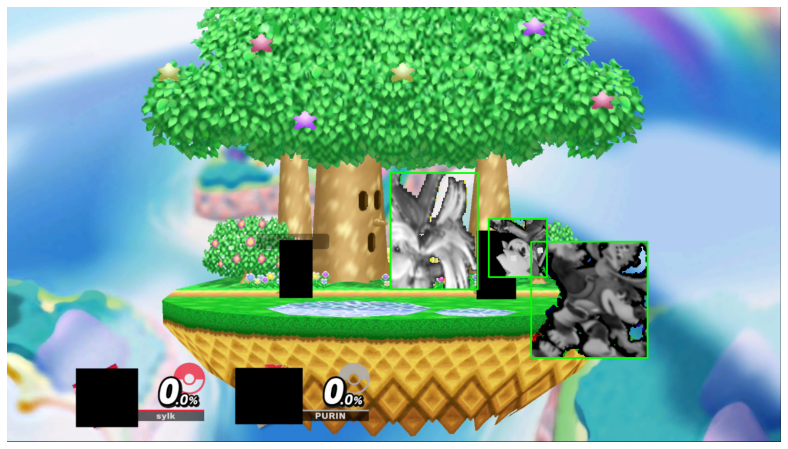

In [217]:
img, boxes, classes = output
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(img, (box[0], box[1]), (box[2],  box[3]), (0, 1, 0), 2)
    
ax.set_axis_off()
ax.imshow(img)
plt.show()

In [31]:
print(CLASSES)
print(len(CLASSES))

['gake', 'マリオ', 'ドンキーコング', 'リンク', 'サムス', 'ダークサムス', 'ヨッシー', 'カービィ', 'フォックス', 'ピカチュウ', 'ルイージ', 'ネス', 'キャプテン・ファルコン', 'プリン', 'ピーチ', 'デイジー', 'クッパ', 'アイスクライマー', 'シーク', 'ゼルダ', 'ドクターマリオ', 'ピチュー', 'ファルコ', 'マルス', 'ルキナ', 'こどもリンク', 'ガノンドロフ', 'ミュウツー', 'ロイ', 'クロム', 'Mr', 'メタナイト', 'ピット', 'ブラックピット', 'ゼロスーツサムス', 'ワリオ', 'スネーク', 'アイク', 'ポケモントレーナー', 'ゼニガメ', 'フシギソウ', 'リザードン', 'ディディーコング', 'リュカ', 'ソニック', 'デデデ', 'ピクミン&オリマー', 'ルカリオ', 'ロボット', 'トゥーンリンク', 'ウルフ', 'むらびと', 'ロックマン', 'Wii Fit トレーナー', 'ロゼッタ&チコ', 'リトル・マック', 'ゲッコウガ', 'パルテナ', 'パックマン', 'ルフレ', 'シュルク', 'クッパJr', 'ダックハント', 'リュウ', 'ケン', 'クラウド', 'カムイ', 'ベヨネッタ', 'インクリング', 'リドリー', 'シモン', 'リヒター', 'キングクルール', 'しずえ', 'ガオガエン', 'パックンフラワー', 'ジョーカー', '勇者', 'バンジョー&カズーイ', 'テリー', 'ベレト', 'ミェンミェン', 'スティーブ', 'セフィロス']
84
